In [1]:
### This script attempts to conduct unsupervised machine learning on 10 years’ 
# worth of LANDSAT data with the aim of creating an animation that shows land use change over time. 

import rasterio as rio
from rasterio.plot import show
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import folium
import os
import fnmatch
import sys
from TOA_reflectance_stacker import histogram_stretch
from tqdm import tqdm
import earthpy.plot as ep
import shapely
from matplotlib.colors import ListedColormap

In [3]:
# Get the current directory
current_directory = os.getcwd()

# List all files in the directory
all_files = os.listdir(current_directory)

# Filter files that contain "STACKED_CROPPED" in their filename
filtered_files = [filename for filename in all_files if "STACKED_CROPPED" in filename]

# these files are automatically sorted by date acquired (filenaming conventions) from oldest
# to youngest
filtered_files

['LC08_L1TP_113037_20140423_20200911_02_T1_TOA_STACKED_CROPPED.tif',
 'LC08_L1TP_113037_20151019_20200908_02_T1_TOA_STACKED_CROPPED.tif',
 'LC08_L1TP_113037_20160514_20200907_02_T1_TOA_STACKED_CROPPED.tif',
 'LC08_L1TP_113037_20180317_20200901_02_T1_TOA_STACKED_CROPPED.tif',
 'LC08_L1TP_113037_20180808_20200831_02_T1_TOA_STACKED_CROPPED.tif',
 'LC08_L1TP_113037_20190507_20200829_02_T1_TOA_STACKED_CROPPED.tif',
 'LC08_L1TP_113037_20200306_20200822_02_T1_TOA_STACKED_CROPPED.tif',
 'LC08_L1TP_113037_20211120_20211130_02_T1_TOA_STACKED_CROPPED.tif',
 'LC08_L1TP_113037_20230502_20230509_02_T1_TOA_STACKED_CROPPED.tif']

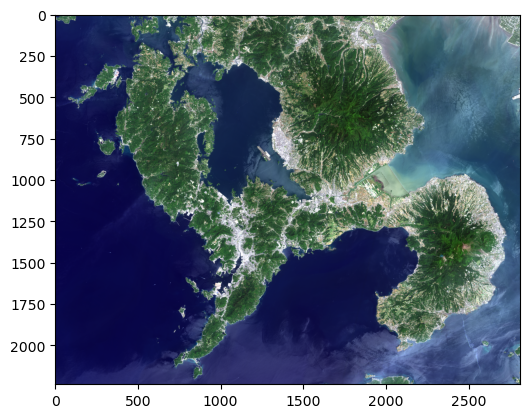

<Axes: >

In [4]:
# select training area for unsupervised learning
src = rio.open(filtered_files[-1])

# Note that you can use src.descriptions to see which band number corresponds to which band
tcc = src.read([4,3,2])

tcc_stretch = histogram_stretch(tcc, 0, 99)

# Full area
show(tcc_stretch)

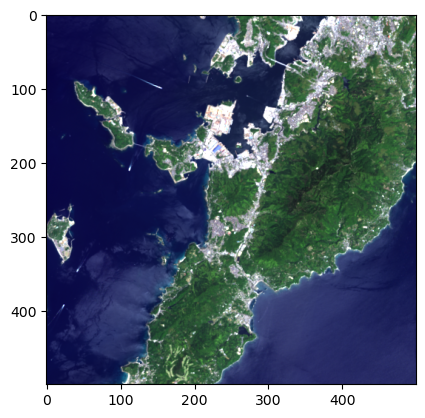

<Axes: >

In [5]:
# Select training area
show(tcc_stretch[:, 1500:2000, 750:1250])

In [6]:
# Training is conducted on all 10 bands
dataset = src.read()

# Remember that you should not conduct A histogram stretch on the training data:
# the histogram stretch is only used for visual clarity.
training = dataset[:, 1500:2000, 750:1250]

# Adjust the shape of the numpy array such that each row corresponds to a pixel
# and each column corresponds to one of the 10 bands

# See Basic Image Classification with ML for an explanation of how this code works
# identify new shape of the data
new_shape = (training.shape[1] * training.shape[2], training.shape[0])
# swap axes and reshape
X = training.swapaxes(0,2).reshape(new_shape)
X

array([[1.26128390e-01, 1.00738525e-01, 5.97687587e-02, ...,
        1.80178136e-03, 2.44801270e+04, 2.29558926e+04],
       [1.26386687e-01, 1.00882344e-01, 6.02488518e-02, ...,
        2.02242006e-03, 2.44802734e+04, 2.29538262e+04],
       [1.27076447e-01, 1.01782382e-01, 6.13182113e-02, ...,
        1.56175275e-03, 2.44815879e+04, 2.29504180e+04],
       ...,
       [1.33005351e-01, 1.08645335e-01, 7.12250918e-02, ...,
        1.28711842e-03, 2.40844375e+04, 2.26011094e+04],
       [1.32707566e-01, 1.09581120e-01, 7.16776326e-02, ...,
        1.25572307e-03, 2.40718398e+04, 2.26046191e+04],
       [1.33715928e-01, 1.09076023e-01, 7.13919178e-02, ...,
        1.35721033e-03, 2.40613867e+04, 2.26070195e+04]], dtype=float32)

In [7]:
from sklearn.preprocessing import StandardScaler

# It is extremely important to scale your data for K-means analysis because K-means
# creates centroids based on the distance between each point. Since our reflectance data 
# ranges between 0 and 1while our thermal emissivity data ranges between 1 and 65535, 
# scaling is incredibly important to prevent the model from overemphasizing thermal emissivity.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

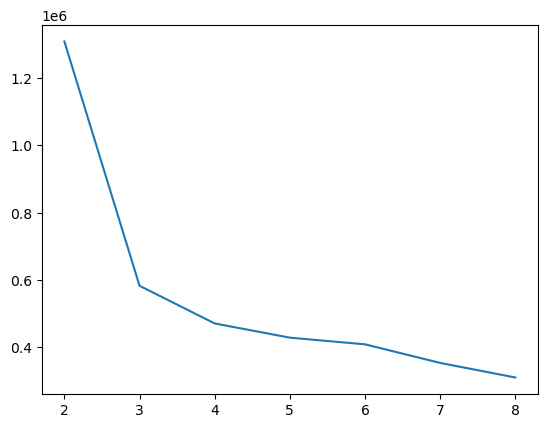

In [8]:
from sklearn.cluster import MiniBatchKMeans

distortion = np.empty(7)
num_clusters = [i for i in range(2,9)]

for i, number in enumerate(num_clusters):
    # Initialize MiniBatchKMeans unsupervised learning model. 
    # MiniBatchKMeans is much faster than normal kmeans models on extremely large datasets. 
    # We set a random state parameter to ensure reproducibility.
    kmeans = MiniBatchKMeans(n_clusters = number, random_state = 42, n_init = 'auto')
    
    # Identify ideal number of clusters based on elbow method
    centroids = kmeans.fit(X_scaled)
    distortion[i] = kmeans.inertia_
    
# In this example, looks like either 3 or 4 is good
# Based on our own classification, 4 was good. 
plt.plot(num_clusters, distortion)
plt.show()

In [9]:
# Initialize kmeans model with four clusters
num_clusters = 4
kmeans = MiniBatchKMeans(n_clusters = num_clusters, random_state = 42, n_init = 'auto')

# y contains a predicted class for each pixel in the image. 
# We can thus reshape this array to recreate our 2D image
y = kmeans.fit_predict(X_scaled)

# Note that we have to transpose the array because we swapped axes earlier
y = y.reshape(training.shape[1], training.shape[2]).T

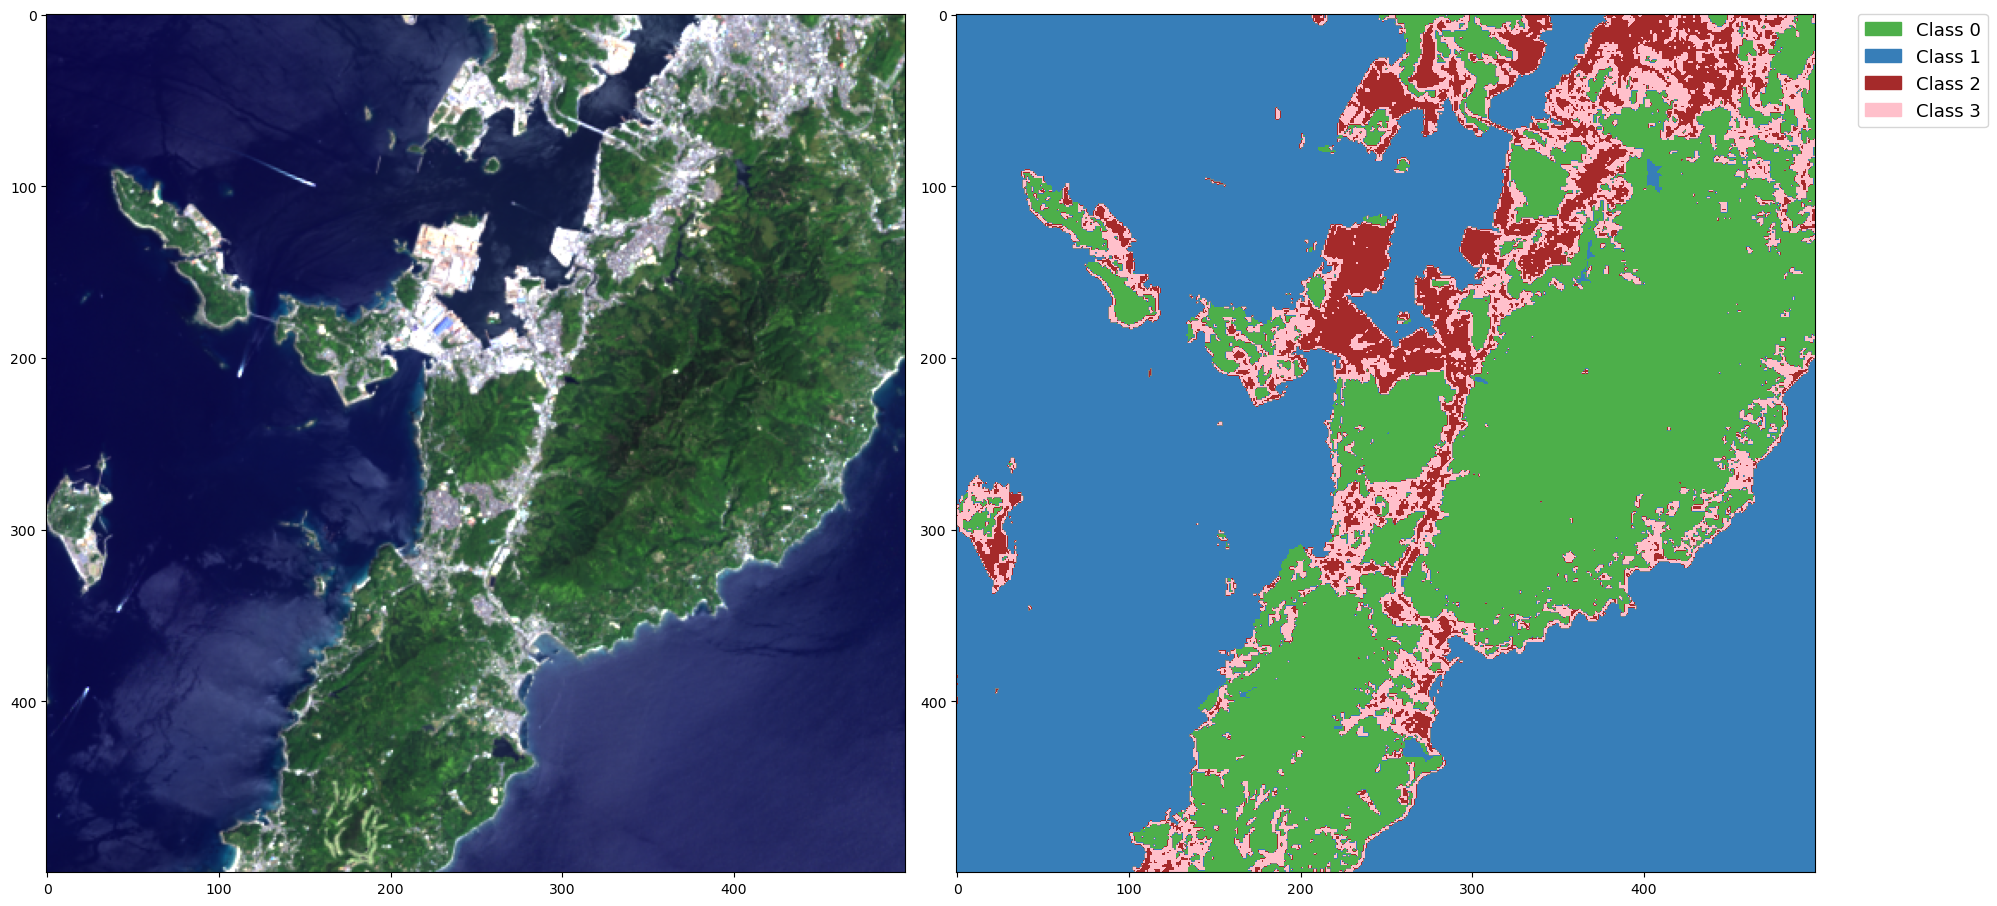

In [10]:
# %matplotlib qt5
#  create a reasonable color map for our data
cmap = ListedColormap(["#4daf4a", "#377eb8", "grey", "brown", "pink"], name = "LULC")

# the results are pretty good: it has very clearly identified the water and the forested 
# areas as well as identifying urban (brown) and cropland areas (pink)
fig, ax = plt.subplots(1,2, figsize = (20,10))
i = ax[1].imshow(y, cmap = cmap)
ax[0].imshow(rio.plot.reshape_as_image(tcc_stretch[:, 1500:2000, 750:1250]))
ep.draw_legend(im_ax = i, titles = [f"Class {num}" for num in range(num_clusters)], cmap = cmap)
plt.tight_layout()

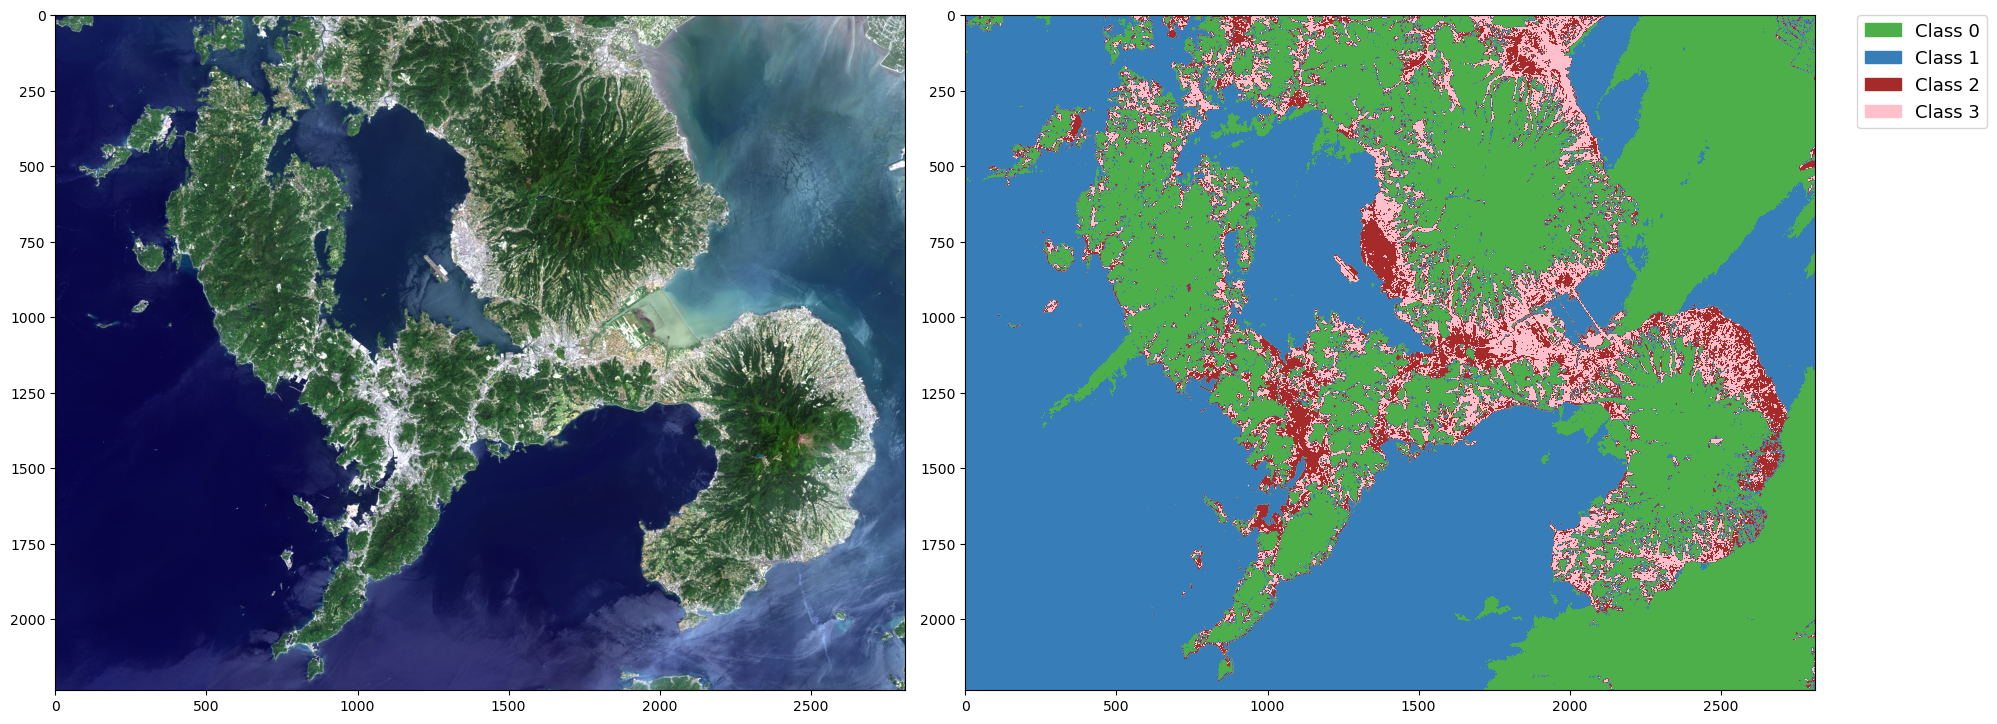

In [11]:
# We can now apply this model to the entire data set

# reshape the data from the entire dataset:
height = dataset.shape[1]
width = dataset.shape[2]

new_shape = (height * width, training.shape[0])
# swap axes and reshape
X_data = dataset.swapaxes(0,2).reshape(new_shape)

# scale and fir the data - note that we do not use "fit" since our models are already trained
X_data = scaler.transform(X_data)
y_labels = kmeans.predict(X_data)

# Reshape back into a 2D array
y_labels = y_labels.reshape(width, height).T

# As you can see this is not the most ideal: some parts of the ocean which have been 
# affected by cloud cover as well as sediment content have been misclassified as forested areas
fig, ax = plt.subplots(1,2, figsize = (20,10))
i = ax[1].imshow(y_labels, cmap = cmap)
ax[0].imshow(rio.plot.reshape_as_image(tcc_stretch))
ep.draw_legend(im_ax = i, titles = [f"Class {num}" for num in range(num_clusters)], cmap = cmap)
plt.tight_layout()

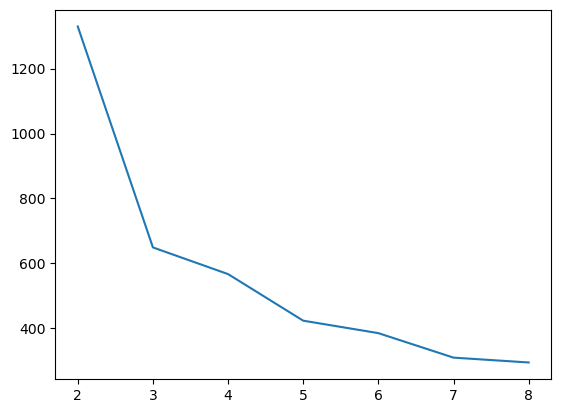

In [11]:
# We have shown previously that using only bands 1 through 7 had better 
# classification results for unsupervised learning.
%matplotlib inline
from sklearn.cluster import MiniBatchKMeans

# The next two code blocks repeat the above workflow but only using bands 1-7
src = rio.open(filtered_files[-1])

# Read in visible and NIR
no_thermal_data = src.read([1,2,3,4,5,6,7])
src.close()

training = no_thermal_data[:, 1500:2000, 750:1250]

new_shape = (training.shape[1] * training.shape[2], training.shape[0])
# swap axes and reshape
X = training.swapaxes(0,2).reshape(new_shape)
X_scaled = scaler.fit_transform(X)

# Elbow method on Bands 1-7
distortion = np.empty(7)
num_clusters = [i for i in range(2,9)]

for i, number in enumerate(num_clusters):
    # Initialize MiniBatchKMeans unsupervised learning model. 
    # MiniBatchKMeans is much faster than normal kmeans models on extremely large datasets. 
    # We set a random state parameter to ensure reproducibility.
    kmeans = MiniBatchKMeans(n_clusters = number, random_state = 42, n_init = 'auto')
    
    # Identify ideal number of clusters based on elbow method
    centroids = kmeans.fit(X)
    distortion[i] = kmeans.inertia_
    
# In this example, looks like either 3 or 4 is good
# Based on our own classification, 4 was good. 
plt.plot(num_clusters, distortion)
plt.show()

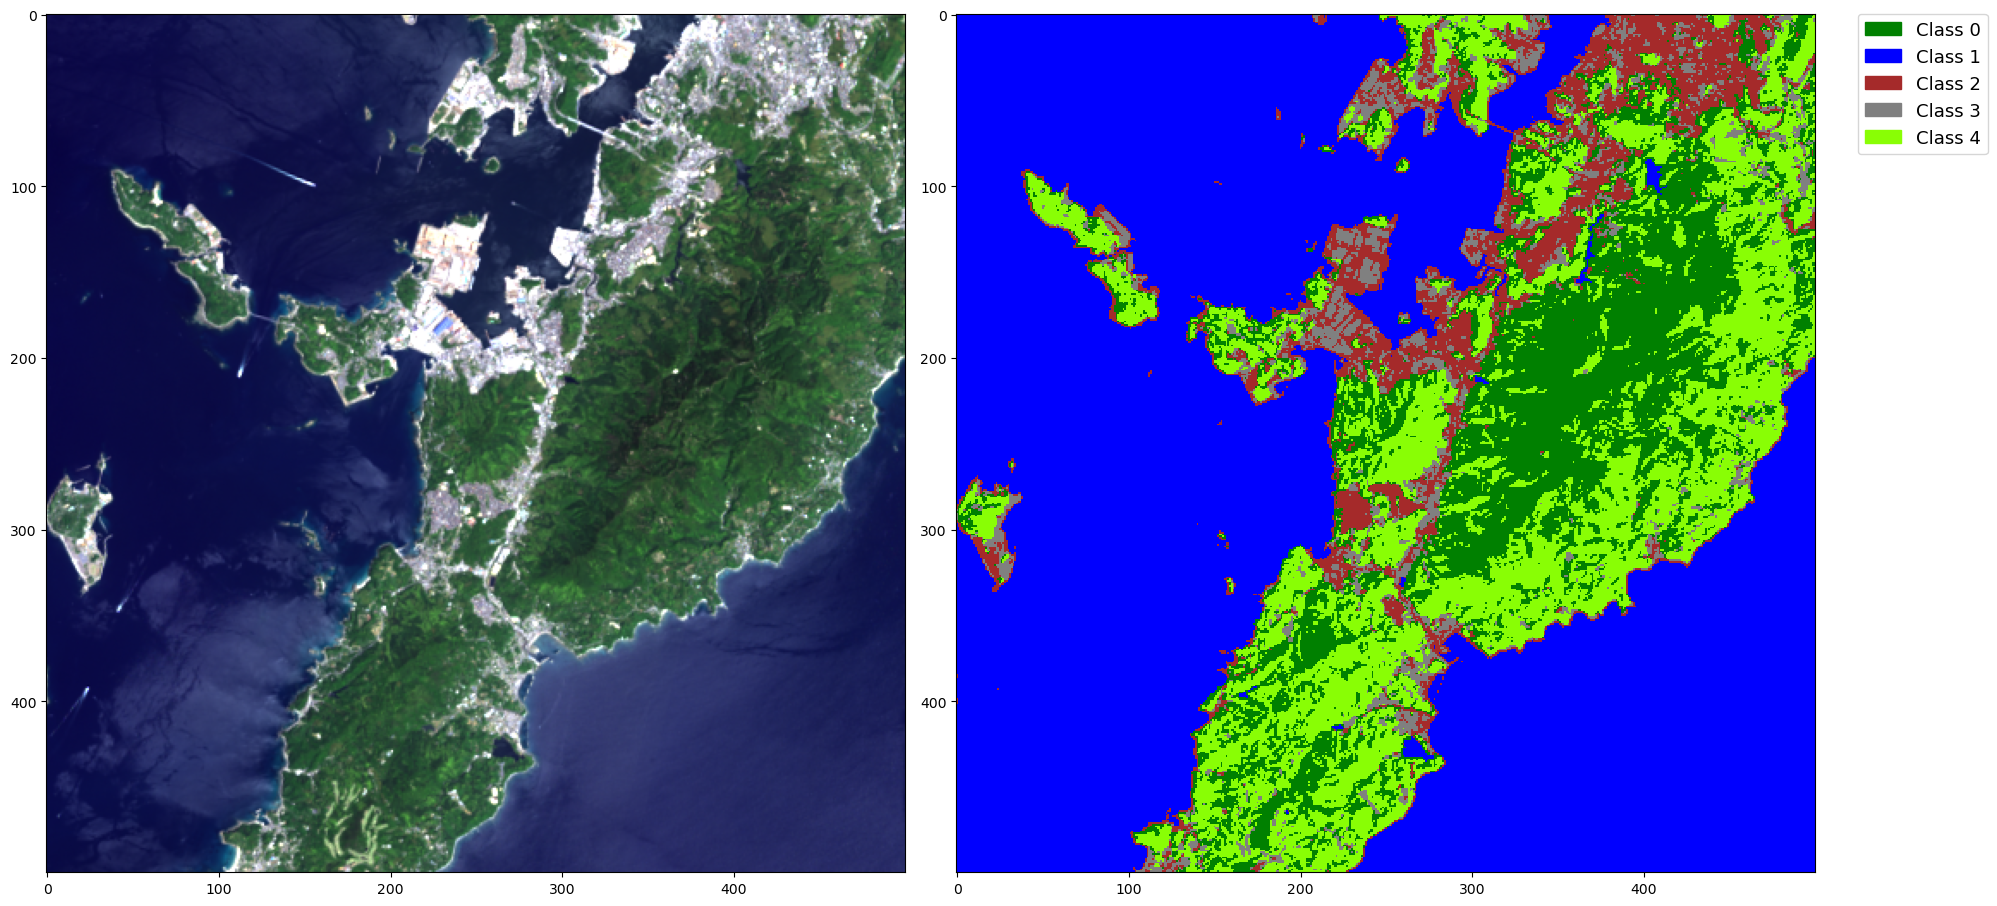

In [12]:
%matplotlib inline

from sklearn.cluster import KMeans

# Initialize kmeans model with five clusters
num_clusters = 5
kmeans = MiniBatchKMeans(n_clusters = num_clusters, random_state = 42, n_init = 'auto')

# Note that we do not need to scale here - bands 1-7 are already on the same scale
# X = scaler.fit_transform(X)

y = kmeans.fit_predict(X)
y = y.reshape(training.shape[1], training.shape[2]).T

if num_clusters == 5:
    cmap = ListedColormap(["green", "blue", "brown", "grey", "xkcd:lime green"], name = "LULC")
else:
    cmap = ListedColormap(["green", "blue", "grey", "xkcd:lime green"], name = "LULC")

# Based on the data here we can see that the 4th class appears to capture the cropland segment
fig, ax = plt.subplots(1,2, figsize = (20,10))
i = ax[1].imshow(y, cmap = cmap, interpolation = "nearest")
ax[0].imshow(rio.plot.reshape_as_image(tcc_stretch[:, 1500:2000, 750:1250]))
ep.draw_legend(im_ax = i, titles = [f"Class {num}" for num in range(num_clusters)], cmap = cmap)
plt.tight_layout()

In [13]:
# reshape the data from the entire dataset:
%matplotlib qt5

height = no_thermal_data.shape[1]
width = no_thermal_data.shape[2]

new_shape = (height * width, no_thermal_data.shape[0])
# swap axes and reshape
X_data = no_thermal_data.swapaxes(0,2).reshape(new_shape)

# scale and fit the data - note that we do not use "fit" since our models are already trained
# X_data = scaler.transform(X_data)
y_labels = kmeans.predict(X_data)

# Reshape back into a 2D array
y_labels = y_labels.reshape(width, height).T

# As you can see this does a much better job of predicting the ocean and does not
# misclassify areas of ocean with sediment or cloud cover, with the exception of some minor
# sediment flows
fig, ax = plt.subplots(1,2, figsize = (20,10))
i = ax[1].imshow(y_labels, cmap = cmap, interpolation = "nearest")
ax[0].imshow(rio.plot.reshape_as_image(tcc_stretch))
ep.draw_legend(im_ax = i, titles = [f"Class {num}" for num in range(num_clusters)], cmap = cmap)
plt.tight_layout()

In [94]:
# We can now attempt to conduct this workflow on the time-series data.
from datetime import datetime

# first, let's create a list of dates from the filenames
# This code is a bit long winded but all it's doing is reformatting the dates from the filenames
# into more human-readable dates
dates = [datetime.strptime(filename.split("_")[3], '%Y%m%d').strftime('%d %B %Y') for filename in filtered_files]

dates

['23 April 2014',
 '19 October 2015',
 '14 May 2016',
 '17 March 2018',
 '08 August 2018',
 '07 May 2019',
 '06 March 2020',
 '20 November 2021',
 '02 May 2023']

In [100]:
# Create a dictionary to store the data
data_dict = {}

# For each cropped file, get the classified data
for i, filename in tqdm(enumerate(filtered_files)):
    src = rio.open(filename)
    data = src.read([1,2,3,4,5,6,7])
    src.close()
    
    # To be honest this should be the same for all rasters, but include just in case you're
    # using rasters of different dimensions for some reason
    height = data.shape[1]
    width = data.shape[2]
    new_shape = (height * width, data.shape[0])

    # swap axes and reshape
    X_data = data.swapaxes(0,2).reshape(new_shape)
    
    # Scale and predict
    # X_data = scaler.transform(X_data)
    y_labels = kmeans.predict(X_data)
    
    y_labels = y_labels.reshape(width, height).T
    
    data_dict[dates[i]] = (data, y_labels)

9it [00:12,  1.35s/it]


In [101]:
# Let's try and do some animations
# To make animations we need to use matplotlib’s FuncAnimation object
# FuncAnimation requires you to provide a function that updates the figure with the next frame of
# the animation

# Specifically, FuncAnimation will pass the function a "frame", which is usually an integer (though
# you can set this using the "frames" argument when you call the FuncAnimation class). Based on this
# frame input, your function will need to tell the ax object what to plot, generally using a
# "set method". A list of set methods for different matplotlib graphs is found here:
# https://matplotlib.org/stable/tutorials/introductory/animation_tutorial.html

# Create a figure and axis for the animation
%matplotlib qt5
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots(1, 2, figsize = (20,10))

if num_clusters == 5:
    cmap = ListedColormap(["green", "blue", "brown", "grey", "xkcd:lime green"], name = "LULC")
elif num_clusters == 4:
    cmap = ListedColormap(["green", "blue", "grey", "xkcd:lime green"], name = "LULC")
else:
    cmap = ListedColormap(["green", "blue", "grey"], name = "LULC")

# Initialize an empty image plot
tcc_plot = ax[0].imshow(rio.plot.reshape_as_image(histogram_stretch(data_dict[dates[0]][0][[3,2,1],:,:], 0, 99)))
lulc_plot = ax[1].imshow(data_dict[dates[0]][1], cmap = cmap, interpolation = "nearest")

if num_clusters == 5:
    ep.draw_legend(im_ax = lulc_plot, titles = ["Forest", "Water", "Cropland", "Urban", "Shaded Forest"], cmap = cmap)
elif num_clusters ==4:
    ep.draw_legend(im_ax = lulc_plot, titles = ["Forest", "Water", "Urban", "Cropland"], cmap = cmap)
else:
    ep.draw_legend(im_ax = lulc_plot, titles = ["Forest", "Water", "Urban"], cmap = cmap)

ax[0].axis("off")
ax[1].axis("off")

def update(frame):
    date = dates[frame]
    
    # load the image from the dictionary
    tcc_image = rio.plot.reshape_as_image(histogram_stretch(data_dict[date][0][[3,2,1],:,:], 0, 99))
    lulc_image = data_dict[date][1]
    
    # set the image onto the figure
    tcc_plot.set_data(tcc_image)
    lulc_plot.set_data(lulc_image)
    
    ax[0].set_title(f"Nagasaki Prefecture Land Use, Unsupervised\n{date}", fontsize = 24, 
                    x = 1, y = 1)

# Call the funk animation class with the appropriate arguments. Frames indicates how many
# frames there will be IE how many frames will be passed into the `update` function, while
# repeat tells matplotlib whether to loop the animation, interval tells FuncAnimation how much time
# between frames
animation = FuncAnimation(fig, update, frames=len(dates), repeat=True, interval = 2000)
plt.tight_layout()

# Save the animation
animation_file = f'{num_clusters}cluster_animation.gif'
animation.save(animation_file, writer='pillow')

plt.show()

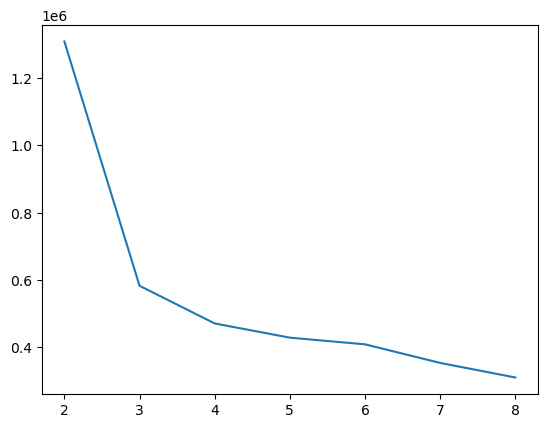

In [132]:
# Gonna give one last attempt to unsupervised training on the November 2021 data set
# We have shown previously that using only bands 1 through 7 had better 
# classification results for unsupervised learning.
%matplotlib inline

# The next two code blocks repeat the above workflow but only using bands 1-7
src = rio.open(filtered_files[-2])

# Read in visible and NIR
no_thermal_data = src.read([1,2,3,4,5,6,7])
src.close()

training = no_thermal_data[:, 1500:2000, 750:1250]

new_shape = (training.shape[1] * training.shape[2], training.shape[0])
# swap axes and reshape
X = training.swapaxes(0,2).reshape(new_shape)

# Elbow method on Bands 1-7
distortion = np.empty(7)
num_clusters = [i for i in range(2,9)]

for i, number in enumerate(num_clusters):
    # Initialize MiniBatchKMeans unsupervised learning model. 
    # MiniBatchKMeans is much faster than normal kmeans models on extremely large datasets. 
    # We set a random state parameter to ensure reproducibility.
    kmeans = MiniBatchKMeans(n_clusters = number, random_state = 42, n_init = 'auto')
    
    # Identify ideal number of clusters based on elbow method
    centroids = kmeans.fit(X_scaled)
    distortion[i] = kmeans.inertia_
    
# In this example, looks like either 3 or 4 is good
# Based on our own classification, 4 was good. 
plt.plot(num_clusters, distortion)
plt.show()

In [136]:
%matplotlib qt5

# Initialize kmeans model with five clusters
num_clusters = 4
kmeans = MiniBatchKMeans(n_clusters = num_clusters, random_state = 42, n_init = 'auto')

# Note that we do not need to scale here - bands 1-7 are already on the same scale
# X = scaler.fit_transform(X)

y = kmeans.fit_predict(X)
y = y.reshape(training.shape[1], training.shape[2]).T

if num_clusters == 5:
    cmap = ListedColormap(["green", "blue", "brown", "grey", "xkcd:lime green"], name = "LULC")
else:
    cmap = ListedColormap(["green", "blue", "grey", "xkcd:lime green"], name = "LULC")

# Nope it did not work - it is clear that in some of the images, shaded forest looks spectrally
# too similar to the ocean. From a theoretical standpoint this is kind of unusual, because the 
# NIR band should very clearly capture vegetation.
fig, ax = plt.subplots(1,2, figsize = (20,10))
i = ax[1].imshow(y, cmap = cmap, interpolation = "nearest")
ax[0].imshow(rio.plot.reshape_as_image(histogram_stretch(no_thermal_data[:, 1500:2000, 750:1250][[3,2,1],:,:], 0, 99)))
ep.draw_legend(im_ax = i, titles = [f"Class {num}" for num in range(num_clusters)], cmap = cmap)
plt.tight_layout()

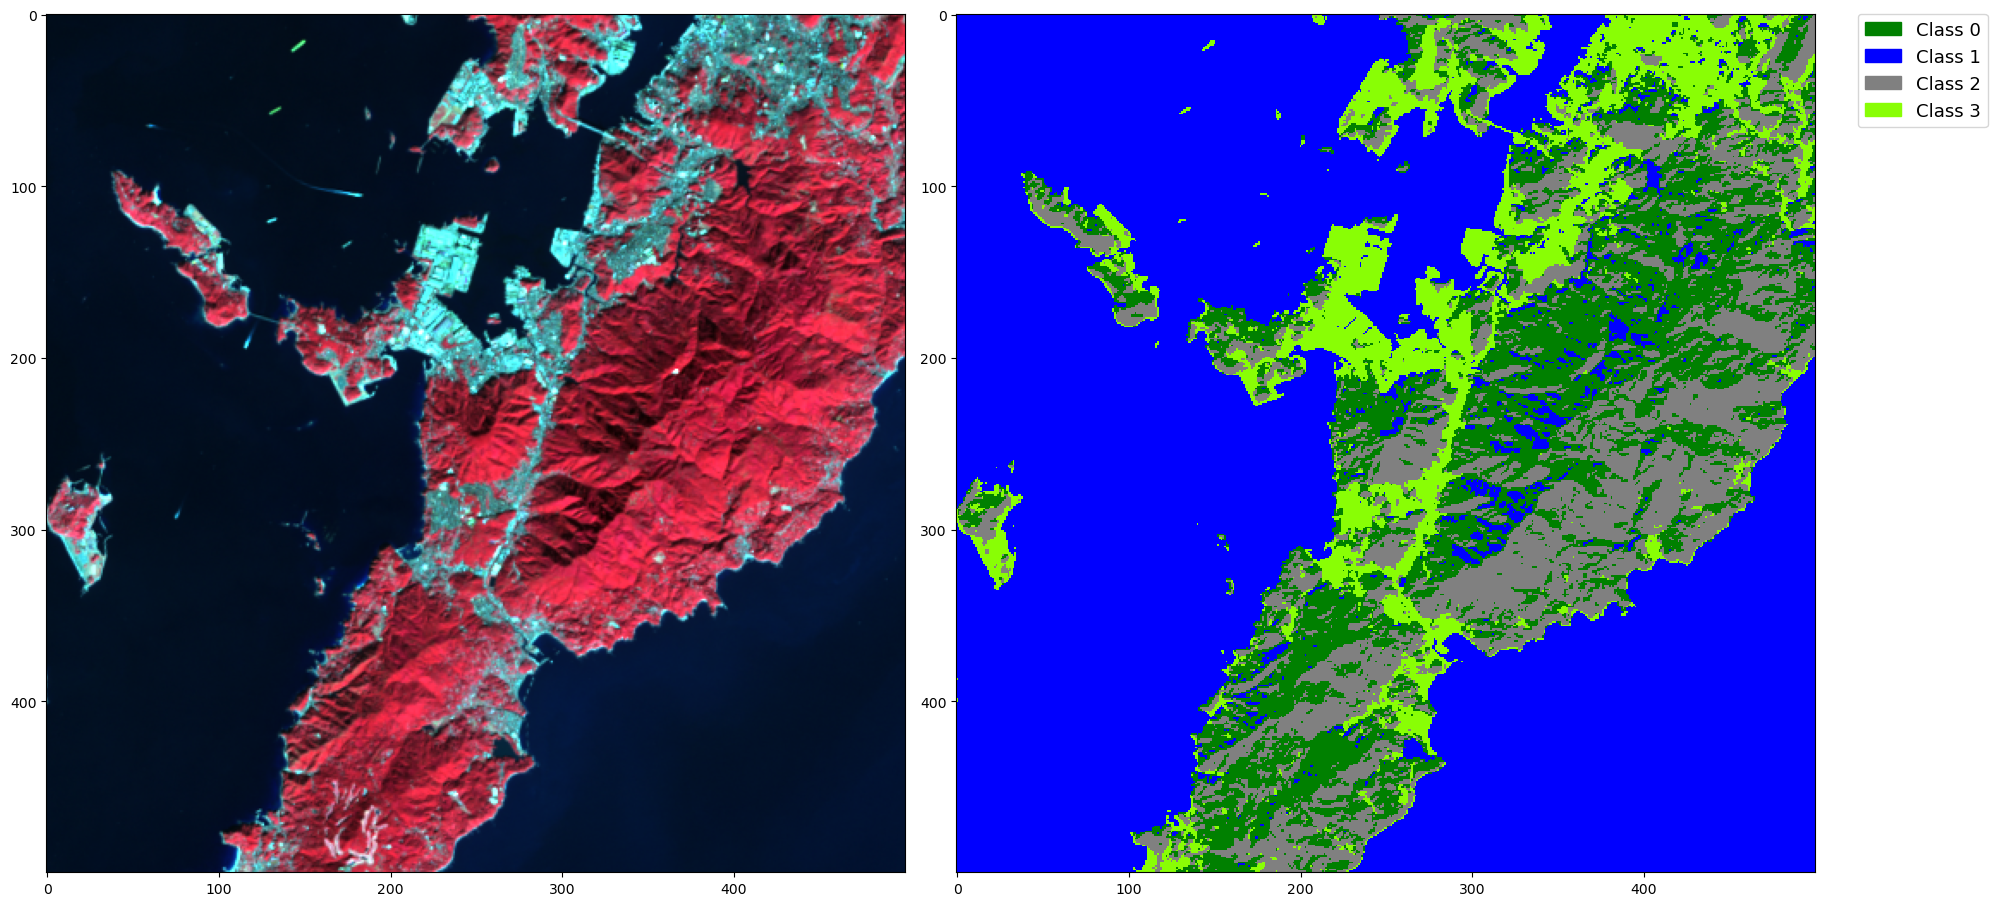

In [137]:
# check 543
%matplotlib inline

# cmap = ListedColormap(["grey", "blue", "xkcd:lime green"], name = "LULC")

fig, ax = plt.subplots(1,2, figsize = (20,10))
i = ax[1].imshow(y, cmap = cmap, interpolation = "nearest")
ax[0].imshow(rio.plot.reshape_as_image(histogram_stretch(no_thermal_data[:, 1500:2000, 750:1250][[4,3,2],:,:], 0, 99)))
ep.draw_legend(im_ax = i, titles = [f"Class {num}" for num in range(num_clusters)], cmap = cmap)
plt.tight_layout()

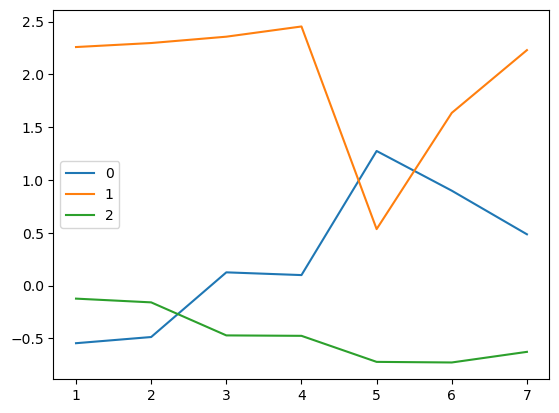

In [130]:
fig, ax = plt.subplots()

y = kmeans.fit_predict(X)
classes = np.unique(y)
for class_type in classes:
    band_intensity = np.mean(X[y==class_type, :], axis=0)
    ax.plot(np.arange(1,8), band_intensity, label=class_type)
ax.legend()

In [ ]:
# So we've managed to make an animation that shows land use over time as classified using an
# unsupervised learning model. There are, however, certainly some improvements that can be made.

# The biggest issue is that in some years some parts of the forest are misclassified as water areas. 
# This is likely because of the differences in shaded relief (i.e, the differences between north- 
# and south-facing forests) in forested areas leading to misclassification. This is still an issue
# even if we only use three clusters for classification. One potential solution is that we can 
# train the data on the rester in which this issue is the most egregious, such as October 2015 or 
# March 2018.

# Another issue is related to cloud cover. This most clearly seen in August 2018, where there is a
# large contrail over the southern half of the map. That said, our model is particularly good at
# identifying the location of water regardless of its sediment content or cloud cover.

# Another issue is that the urban and cropland classes sometimes appear to be attributed differently
# at different times. This may be because the two classes are spectrally similar: consequently, even 
# minor changes in atmospheric conditions may result in the two classes being misclassified. 

# Unfortunately, this appears to be the limit of unsupervised learning. One of the benefits
# of supervised learning is that we can specifically train our model to identify these areas, 
# forcing it to recognise the difference between shaded forested areas and water areas

# One final limitation that we must recognize is that these photographs were taken at different
# seasons of the year. Consequently some of the misattributions between urban and cropland areas 
# may not actually be misclassifications: instead it could be cropland turning it into bare land 
# during the winter seasons. Unfortunately there's not much to be done about this these 
# particular rasters were chosen due to their lack of cloud cover

In [48]:
# Check 
%matplotlib qt5
map_number = 0

# Quite interesting. It seems that even very slight amounts of cloud cover can have a
# strong effect on the predictive ability of the unsupervised learning method. 
### It turns out that the issue was to do with the fact that when we corrected for sun elevation, 
### I used np.sin but fed it degrees rather than radians. 

# It appears that now one of the major issues is that some forested areas
# are being misclassified as water. This issue appears to be related to sun angles and shade
fig, ax = plt.subplots(1,2, figsize = (20,10))
i = ax[1].imshow(data_dict[dates[map_number]][1], cmap = cmap, interpolation = "nearest")
ax[0].imshow(rio.plot.reshape_as_image(histogram_stretch(data_dict[dates[map_number]][0][[3,2,1],:,:], 0, 99)))
# ax[0].imshow(rio.plot.reshape_as_image(data_dict[dates[map_number]][0][[3,2,1],:,:]))
ep.draw_legend(im_ax = i, cmap = cmap)
ax[0].set_title(dates[map_number])
plt.tight_layout()

In [130]:
# data_dict[dates[0]][0][[3,2,1],:,:]
src

array([[[-0.05047444, -0.05038682, -0.05069977, ..., -0.08789661,
         -0.10434914, -0.11965155],
        [-0.05036106, -0.05035023, -0.0506391 , ..., -0.08380463,
         -0.10623561, -0.13270229],
        [-0.05009382, -0.05049276, -0.05096726, ..., -0.06675754,
         -0.07790753, -0.09822051],
        ...,
        [-0.04299796, -0.04252031, -0.04250347, ..., -0.05473256,
         -0.05560948, -0.06202219],
        [-0.04292794, -0.04252986, -0.04254449, ..., -0.057017  ,
         -0.05837248, -0.05988216],
        [-0.04284599, -0.0424692 , -0.0425054 , ..., -0.05472178,
         -0.05748167, -0.06009268]],

       [[-0.07271   , -0.07282724, -0.07281592, ..., -0.10550842,
         -0.11527847, -0.1235952 ],
        [-0.07244085, -0.07251739, -0.07266232, ..., -0.1006839 ,
         -0.11689012, -0.13831712],
        [-0.07217435, -0.07246734, -0.07262984, ..., -0.09162052,
         -0.09957638, -0.11255898],
        ...,
        [-0.06319904, -0.06307697, -0.0631225 , ..., -

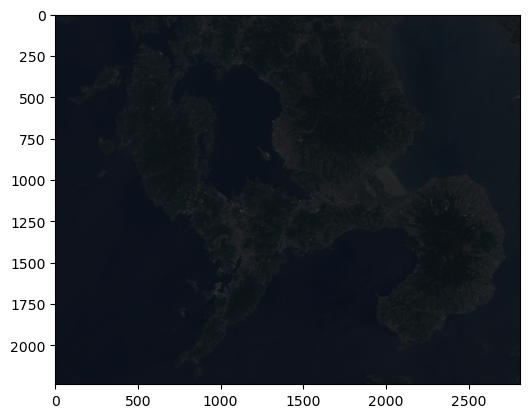

<Axes: >

In [153]:
src = rio.open("LC08_L1TP_113037_20140423_20200911_02_T1_TOA_STACKED_CROPPED.TIF")

test = src.read([4,3,2])

show(test)

In [152]:
import math

toa_no_suncorr / np.sin(np.deg2rad(61.65574580))

array([[0.12707489, 0.12709762, 0.12691582, ..., 0.12682492, 0.12593867,
        0.12648406],
       [0.12687037, 0.12702944, 0.12743848, ..., 0.1267113 , 0.12630226,
        0.12687037],
       [0.12716579, 0.12705217, 0.1268022 , ..., 0.12641588, 0.12677948,
        0.12730214],
       ...,
       [0.12275726, 0.12264363, 0.12309812, ..., 0.11553089, 0.1153491 ,
        0.11528092],
       [0.12282543, 0.12259818, 0.12302995, ..., 0.11555362, 0.11573541,
        0.11541727],
       [0.12275726, 0.12255274, 0.12255274, ..., 0.11591721, 0.11598538,
        0.11564452]])

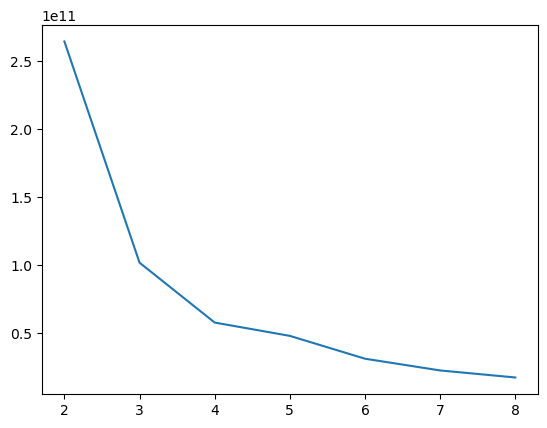

In [35]:
from sklearn.cluster import k_means

distortion = np.empty(7)
num_clusters = [i for i in range(2,9)]

for i, number in enumerate(num_clusters):
    # Initialize MiniBatchKMeans unsupervised learning model. 
    # MiniBatchKMeans is much faster than normal kmeans models on extremely large datasets. 
    # We set a random state parameter to ensure reproducibility.
    centroids, labels, distortion[i] = k_means(X, n_clusters = number, random_state = 42, n_init = 'auto')
    
# In this example, looks like either 3 or 4 is good
# Based on our own classification, 4 was good. 6 has a surprisingly decent improvement as well
plt.plot(num_clusters, distortion)
plt.show()

ValueError: The number of classes should equal the number of titles. You have provided 5 classes and 4 titles.

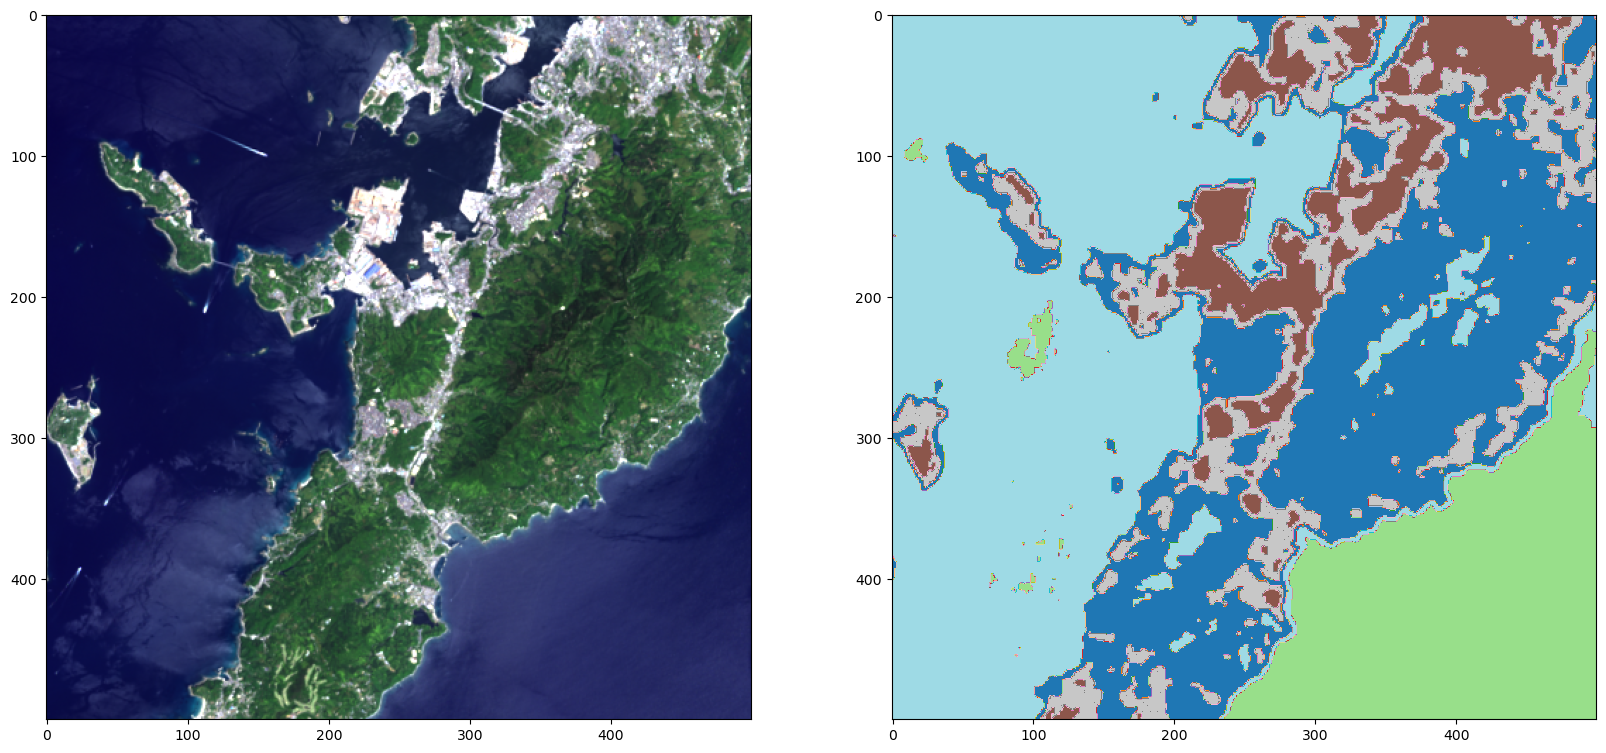